In [1]:
import cv2
from os import makedirs
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def display_image(img):
    '''Displays an image.'''
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
def extract_word_images_from_paragraph_image(img, gray, max_horizontal_gap=11, max_vertical_gap=20):
    '''Returns a list of words and their images from a paragraph image.'''
    # Threshold the image
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Group contours that are close together horizontally and vertically
    grouped_contours = []
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        if h < 5 or w < 7: continue
        # Check if the contour is close to any existing group (left close to right or vice versa, y similar)
        added_to_group = False
        for group in grouped_contours:
            for x2, y2, w2, h2 in group:
                if (abs(x - (x2 + w2)) < max_horizontal_gap or abs(x+w - x2) < max_horizontal_gap) and abs(y - y2) < max_vertical_gap:
                    group.append((x, y, w, h))
                    added_to_group = True
                    break
            if added_to_group: break
                
                
        # If the contour is not close to any existing group, create a new group
        if not added_to_group:
            grouped_contours.append([(x, y, w, h)])

    # Create a list for words
    word_list = []
    padding = 3
    # For each group of contours
    for group in grouped_contours:
        # Sort the contours in the group from left to right
        group = sorted(group, key=lambda x: x[0])
        # Merge the contours in the group into a single bounding box
        x = group[0][0]
        y = min([ctr[1] for ctr in group])
        w = max([ctr[0] + ctr[2] for ctr in group]) - x
        h = max([ctr[1] + ctr[3] for ctr in group]) - y
        # Draw the bounding box
        cv2.rectangle(img, (x-padding, y-padding), (x+w+padding, y+h+padding), (0, 255, 0), 2)
        # Crop the bounding box region
        word_img = gray[y-padding:y+h+padding, x-padding:x+w+padding]
        # Add the word to the list
        word_list.append(word_img)
        
    # Display the image
    display_image(img)
    
    # Return the list
    return word_list

In [6]:
max_horizontal_gap = 15
max_vertical_gap = 20
num_lines = 2
line_width = 64

imgs = ['anita-1', 'dhruv-1', 'shambu-1', 'taha-1']
image_path = ['../../../DataSet/' + img + '.jpeg' for img in imgs]

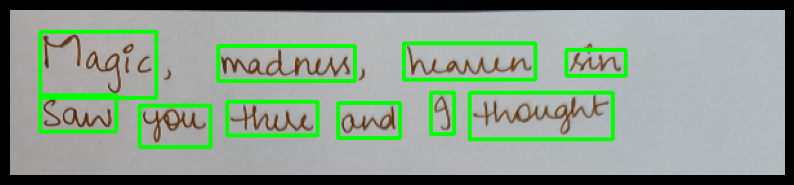

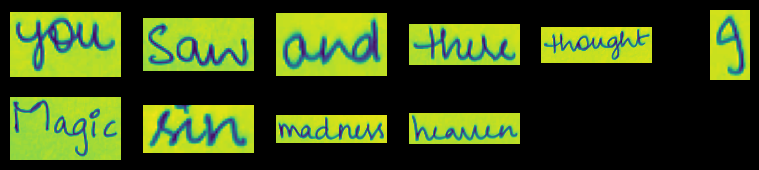

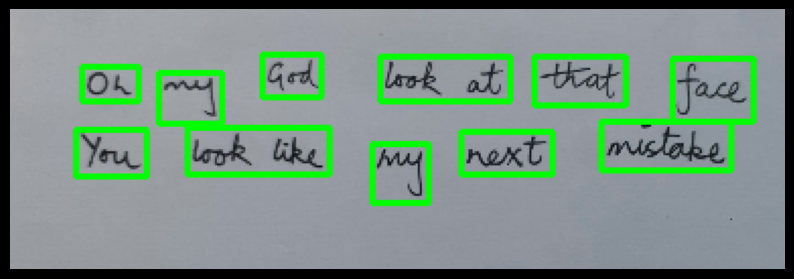

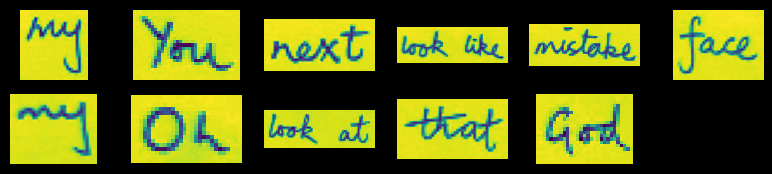

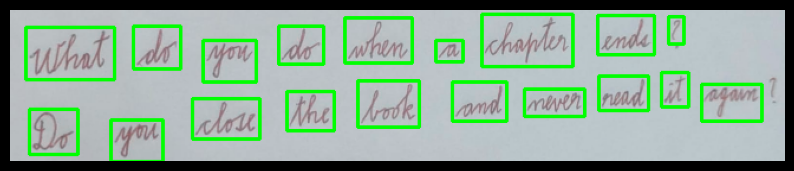

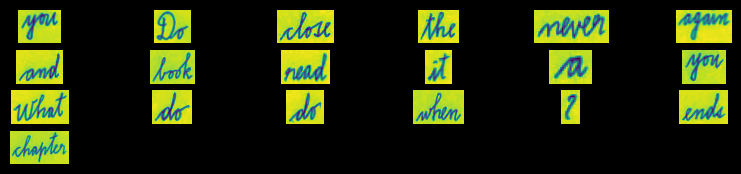

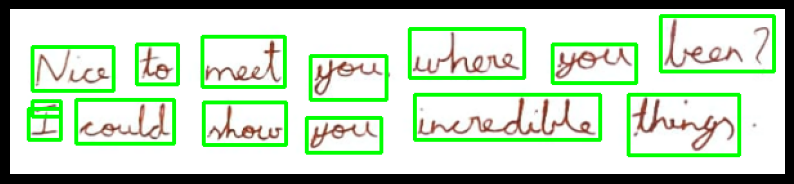

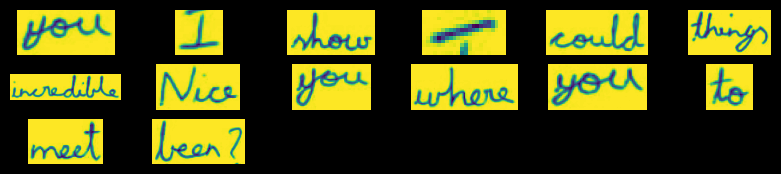

In [7]:
# Segment the words in the image
for j, img_path in enumerate(image_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (int(img.shape[1]*num_lines*line_width/img.shape[0]), num_lines*line_width)) # Resize image to be num_lines * 64 pixels tall
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # gray[gray > 100] = 255 # To remove notebook rule lines (Remove if no rule lines)
    word_images = extract_word_images_from_paragraph_image(img, gray, max_horizontal_gap, max_vertical_gap)
    
    # Save the word images
    makedirs(f'../DataSet/{imgs[j]}', exist_ok=True)
    for i, word_image in enumerate(word_images):
        cv2.imwrite(f'../DataSet/{imgs[j]}/{i}.png', word_image)
        
    # Display the word images
    plt.figure(figsize=(10, 2))
    for i, word_image in enumerate(word_images):
        plt.subplot( (len(word_images)+5)//6, 6, i+1)
        plt.imshow(word_image)
        plt.axis('off')
    plt.show()